### Imports

In [2]:

import networkx as nx
import numpy as np
import random, math
import graphviz
import functools, collections, operator

import time

import kaleido

import pandas as pd

import scipy as sp
from scipy import stats


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import plotly.graph_objects as go
from pyvis.network import Network
from networkx.drawing.nx_agraph import graphviz_layout
import plotly.express as px


# import models
#from classes.jackson_model import JacksonSimulationV2
from classes.network_drawing import plotly_sim_drawing


Jackson model
* Start with m nodes
* New nodes are introduced to m nodes
* Befriend with probability pm
* New nodes are then introduced to n of those pm nodes' connections
* Befriend with probability pn
* Continue for as many iterations as would like

### Simulation version 2

Updates:
* Attributes of encountered nodes (i.e., the exposure group)
* CORRECTED: will now find parent neighbours even if not connected to parents
* Rewrtitten connection search functions to include two stages for easier access to targets/connection group
* Add connection chance as f of cross/within
* Create function to check number of cross/within depending on the group
* Caluclate SES assortativity

TODO

High SES individuals have 25.4% more friends on average

Create functions for
* Calculate average bias and exposure for nodes in the network
* Calculate all 5 characteristics of real social networks
* Find a measure of segregation on networks?
* Making samples / lots of simulations, and timing them 




In [60]:

class JacksonSimulationV2():

    def __init__(self, initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased = False, rho = 1, epsilon = 1):

        # parameters
        self.initial_n = initial_n # initial number of nodes
        self.T = T # number of iterations / final nodes - initial_n
        self.m = m # number of parent nodes encountered
        self.pm_o = pm_o # probability of befriending a parent node of same SES
        self.n = n # number of parent neighbour nodes encountered
        self.pn_o = pn_o # probability of befriending parent neighbour nodes of same SES
        self.p_SES_high = p_SES_high # probability of each node's SES to be High
        self.biased = biased # whether or not to use a class-biased simulation
        self.rho = rho # ratio (within friendship probatility)/(cross friendship probatility): rho = how many times more likely to befriend within-class than across-class (rho = 2 => twice as likely, rho = 1/3 => three times less likely)
        # NB rho is initialised as 1, hence no bias, per default. If biased, specify rho value
        self.epsilon = epsilon
        
        # calculate cross-friendship probabilities: rho = po/px => px = po/rho
        self.pm_x = pm_o / rho
        self.pn_x = pn_o / rho

        if biased == True and (rho == 1 or epsilon == 1):
            print('Warning: Biased simulation requested, but rho = 1.')
        if biased == False and rho != 1:
            print(f'Warning: Unbiased simulation requested, but rho = {self.rho}')

        # also maybe add options for the functions used
        # self.initialiser_function = 

        # simulation memory
        self.period = 0
        self.graph_history = []
        # will also need a matrix history to make it easier to save simulations to a csv or the like

        # starting stuff
        #self.initial_nodes = [i+1 for i in range(initial_n)] # create n initial nodes, +1 for name to start at 1

        self.main()


    '''MAIN'''
    def main(self):
        # make the initial graph
        self.save_update_to_memory(self.initial_node_connector_basic())


        for t in range(self.T):
            self.update_simulation(self.graph_history[-1])

        # calculate exposure and friending bias




    '''INITIALISATION'''
    # basic version: all nodes get a certain number of connections
    def initial_node_connector_basic(self):
        initial_graph = nx.Graph()

        # add nodes until we have enough to start with
        while len(initial_graph.nodes) < self.initial_n:
            new_node = self.new_node_birth(initial_graph)
            initial_graph.add_nodes_from([new_node])


        #initial_graph.add_nodes_from(self.initial_nodes)

        initial_nodes = list(initial_graph.nodes)


        for node in initial_nodes:
            possible_links = initial_nodes.copy()
            possible_links.remove(node) # remove own node
            
            # randomly chooses m+n nodes without replacement from the initial nodes to connect (correction for taking the number of nodes instead if m+n>initial_n)
            initial_neighbours = list(np.random.choice(possible_links, min(self.m + self.n, self.initial_n-1), replace=False))
            
            # creates the edges
            initial_edges = self.helper_functions().edge_creator_helper(node, initial_neighbours)
            initial_graph.add_edges_from(initial_edges)

        return initial_graph


    '''UPDATING'''
    # big simulation update
    def update_simulation(self, current_graph):


        # copy graph with the added connections
        new_graph = current_graph.copy()

        '''maybe make this whole thing into a function'''
        # add the new node
        new_node = self.new_node_birth(current_graph) # DONE
        new_graph.add_nodes_from([new_node])

        # get the connections for the new node
        parent_targets = self.find_parent_nodes_targets(self.graph_history[-1], new_node[1]['SES_High']) # DONE
        parent_neighbour_targets = self.find_parent_neighbour_targets(self.graph_history[-1], parent_targets, new_node[1]['SES_High']) # DONE


        # add the exposure group of the node to its attributes
        new_node_targets = list(np.concatenate((parent_targets, parent_neighbour_targets)))
        new_node[1]['Exposure Group'].extend(new_node_targets)

        # get the connections based on the targets
        new_node_edges = self.new_node_connections(new_node, parent_targets, parent_neighbour_targets, new_graph)


        # add the connections
        new_graph.add_edges_from(new_node_edges)

        # save and update
        self.save_update_to_memory(new_graph)
        self.period += 1


    # save to history
    def save_update_to_memory(self, updated_graph):
        # save new graph to history
        '''may need to make a history for t as well, if I end up not creating new nodes every iteration'''
        self.graph_history.append(updated_graph)


    # create new node, indexed as the next number in the list
    def new_node_birth(self, graph, MTO_sim = False):
        current_nodes = graph.nodes()
        new_node = max(current_nodes) + 1 if len(current_nodes) > 0 else 1

        '''currently SES determined at birth, this can be changed'''
        new_node_SES = np.random.choice([1, 0], 1, p=[self.p_SES_high, 1-self.p_SES_high])[0]

        if MTO_sim == True:
            new_node = 'MTO'
            new_node_SES = 0

        return (new_node, {'SES_High': new_node_SES, 'Exposure Group': []})


    # find parent nodes connections
    def find_parent_nodes_targets(self, graph, new_node_SES):
        # get the current existing nodes
        current_nodes = graph.nodes()

        # calculate probability of encountering each node: weight of 1 if same SES, 1/epsilon if different (epsilon times less likely)
        parent_weights = [1 if self.helper_functions().get_select_node_attributes(graph, 'SES_High', [node])[node] == new_node_SES else 1/self.epsilon for node in current_nodes]
        parent_probs = [prob / sum(parent_weights) for prob in parent_weights] # normalise by dividing by total number of nodes

        # checks if empty graph, nothing significant
        if len(current_nodes) > 0:
            parent_targets = np.random.choice(current_nodes, min(self.m, len(current_nodes)), replace=False, p=parent_probs)
        else:
            parent_targets = np.random.choice(current_nodes, min(self.m, len(current_nodes)), replace=False)

        # get m parent nodes
        #parent_targets = np.random.choice(current_nodes, min(self.m, len(current_nodes)), replace=False)

        return parent_targets


    # find parent neighbour connections
    def find_parent_neighbour_targets(self, graph, parent_target_list, new_node_SES):
        # take the list of parents and find their (unique) neighbours
        parent_neighbours = np.unique(self.helper_functions().find_neighbours(graph, parent_target_list))

        # to avoid issues: if the parents have in total less than n neighbours, take their number of neighbours instead
        n_possible_encounters = min(len(parent_neighbours), self.n)

        
        # calculate probability of encountering each node: weight of 1 if same SES, 1/epsilon if different (epsilon times less likely)
        parent_neighbour_weights = [1 if self.helper_functions().get_select_node_attributes(graph, 'SES_High', [node])[node] == new_node_SES else 1/self.epsilon for node in parent_neighbours]
        parent_neighbour_probs = [prob / sum(parent_neighbour_weights) for prob in parent_neighbour_weights] # normalise by dividing by total number of nodes

        # checks if empty graph, nothing significant
        if len(parent_neighbours) > 0:
            parent_neighbour_targets = np.random.choice(parent_neighbours, n_possible_encounters, replace=False, p=parent_neighbour_probs)
        else:
            parent_neighbour_targets = np.random.choice(parent_neighbours, n_possible_encounters, replace=False)


        # get n parent neighbour nodes
        #parent_neighbour_targets = np.random.choice(parent_neighbours, n_possible_encounters, replace=False)

        return parent_neighbour_targets


    # returns a list of connections to form based on targets and probabilties
    def new_node_connections(self, new_node, parent_target_list, parent_neighbour_target_list, graph):
          
        '''
        UGLY AF list comprehension: do not use but fun
        [np.random.choice([0,1], size=1, p=[1-prob, prob])[0] for prob in [po if edge_type == 'cross' else px for edge_type in [SES_edge_classifier(G, 1, i) for i in targets]]]
        '''

        '''parents'''
        # probability pm to connect to each m of them
        # first get edge types
        parent_edge_types = [self.helper_functions().SES_edge_classifier(graph, new_node[0], i) for i in parent_target_list]
        # get list of probs depending on the probs
        parent_edge_probs = [self.pm_x if edge_type == 'cross' else self.pm_o for edge_type in parent_edge_types]
        # realised outcome per prob: vector of connections
        parent_edges = [np.random.choice([0,1], size=1, p=[1-prob, prob])[0] for prob in parent_edge_probs]

        # realised connections: cross product of the two vectors
        parent_connections = parent_target_list * parent_edges
        parent_connections = parent_connections[parent_connections > 0] # filter out the ones with no connection

        '''parent neighbours'''
        # probability pn to connect to each n of them
        parent_neighbour_edge_types = [self.helper_functions().SES_edge_classifier(graph, new_node[0], i) for i in parent_neighbour_target_list]
        parent_neighbour_edge_probs = [self.pm_x if edge_type == 'cross' else self.pm_o for edge_type in parent_neighbour_edge_types]
        parent_neighbour_edges = [np.random.choice([0,1], size=1, p=[1-prob, prob])[0] for prob in parent_neighbour_edge_probs]

        # realised connections: cross product of the two vectors
        parent_neighbour_connections = parent_neighbour_target_list * parent_neighbour_edges
        parent_neighbour_connections = parent_neighbour_connections[parent_neighbour_connections > 0] # filter out the ones with no connection


        '''form the connections'''
        # combine the two
        new_node_connections = np.concatenate((parent_connections, parent_neighbour_connections))
        new_node_edges = self.helper_functions().edge_creator_helper(new_node[0], new_node_connections)


        return new_node_edges



    # calculates exposure and friending bias across the graph
    def graph_exposure_friending_bias(self, graph, return_dicts = False, return_hist_lists = False, node_target = None):       
        # calculates exposure and friending bias for a given node. Returns a dict with the two
        def node_exposure_friending_bias(graph, node):
            
            # gets the exposure group of the given node: number of H nodes encountered
            exposure_group = self.helper_functions().get_select_node_attributes(graph, 'SES_High', graph.nodes()[node]['Exposure Group'])

            n_encountered = len(list(exposure_group.values()))
            n_H_encountered = sum(list(exposure_group.values()))
            node_SES = graph.nodes[node]['SES_High']

            # remove initial nodes
            if n_encountered == 0:
                exposure = 0
                friending_bias = 0
            
            # calculate correctly if encounter some H nodes
            elif n_H_encountered != 0:
                exposure = n_H_encountered / ((n_encountered)*self.p_SES_high)

                '''alternative here: n_H_encountered / n_encountered'''
                '''HAVE A SECOND LOOK AT THIS'''

                neighbours_types = self.helper_functions().find_neighbour_types(graph)
                # take the appropriate dict from the former
                # calculate share of friends who are H
                if node_SES == 1:
                    friend_H_share = neighbours_types[0][node]['H Share']
                else:
                    friend_H_share = neighbours_types[1][node]['H Share']

                # friending bias: 1 - share of H friends / share of H encounters (=0 if no bias)
                friending_bias = 1 - friend_H_share / n_H_encountered
            
            else:
                exposure = n_H_encountered / ((n_encountered)*self.p_SES_high)
                friending_bias = 0


            return {'Exposure Effect': exposure, 'Friending Bias': friending_bias, 'SES': node_SES}

        # if requested for a specific node, just return that directly
        if node_target != None:
            return node_exposure_friending_bias(graph, node_target)

        # list for each
        H_expo, H_bias = [], []
        L_expo, L_bias = [], []

        node_dict = {}


        nodes = graph.nodes()
        for node in nodes:
            node_expo_fb = node_exposure_friending_bias(graph, node)

            if node_expo_fb['SES'] == 1:
                H_expo.append(node_expo_fb['Exposure Effect'])
                H_bias.append(node_expo_fb['Friending Bias'])
            else:
                L_expo.append(node_expo_fb['Exposure Effect'])
                L_bias.append(node_expo_fb['Friending Bias'])

            # append to the dict if requested
            if return_dicts == True:
                node_dict[str(node)] = node_expo_fb


        # take averages in each category
        H_expo_avg, H_bias_avg = sum(H_expo)/len(H_expo), sum(H_bias)/len(H_bias)
        L_expo_avg, L_bias_avg = sum(L_expo)/len(L_expo), sum(L_bias)/len(L_bias)
        all_expo_avg = (sum(H_expo)+sum(L_expo)) / (len(H_expo) + len(L_expo))
        all_bias_avg = (sum(H_bias)+sum(L_bias)) / (len(H_bias) + len(L_bias))

        values_dict = {'All': (all_expo_avg, all_bias_avg),
                       'High': (H_expo_avg, H_bias_avg),
                       'Low': (L_expo_avg, L_bias_avg)}
        
        return values_dict
        '''later, incorporate returning hists etc but who cares now'''

    '''MOVING TO OPPORTUNITY SIMULATION'''

    # main sim

    

    def MTO_sim_many(self, graph, n_sims = 1):
        # do it once
        def MTO_sim(graph):

            MTO_graph = graph.copy()

            MTO_node = self.new_node_birth(graph, MTO_sim=True)
            MTO_graph.add_nodes_from([MTO_node])

            # get the connections for the new node
            parent_targets = self.find_parent_nodes_targets(self.graph_history[-1]) # DONE
            parent_neighbour_targets = self.find_parent_neighbour_targets(self.graph_history[-1], parent_targets) # DONE


            # add the exposure group of the node to its attributes
            new_node_targets = list(np.concatenate((parent_targets, parent_neighbour_targets)))
            MTO_node[1]['Exposure Group'].extend(new_node_targets)

            # get the connections based on the targets
            new_node_edges = self.new_node_connections(MTO_node, parent_targets, parent_neighbour_targets, MTO_graph)


            # add the connections
            MTO_graph.add_edges_from(new_node_edges)


            '''Calculate stuff'''
            MTO_H_Share = self.helper_functions().find_neighbour_types(MTO_graph)[1]['MTO']['H Share']
            Chetty_chars = self.graph_exposure_friending_bias(MTO_graph, node_target='MTO')
            Exposure, Friend_Bias = Chetty_chars['Exposure Effect'], Chetty_chars['Friending Bias']
            N_exposure = len(MTO_node[1]['Exposure Group'])
            Degree = dict(MTO_graph.degree())['MTO']

            return MTO_H_Share, Exposure, Friend_Bias, N_exposure, Degree

        col_names = ['H_Share', 'Exposure', 'Friend_Bias', 'N_exposure', 'Degree']

        # just return a dict if only one sim
        if n_sims == 1:
            return dict(zip(col_names, MTO_sim(graph)))
        

        list_results = [MTO_sim(graph) for i in range(n_sims)]

        df_results = pd.DataFrame(list_results, columns=col_names)



        return df_results



    class helper_functions:
        '''useful functions'''
        # return the indicated attribute for a list of nodes
        def get_select_node_attributes(self, graph, attribute, node_list):
            attribute_dict_all_nodes = nx.get_node_attributes(graph, attribute)
            attribute_dict = {node: attribute_dict_all_nodes[node] for node in node_list}

            return attribute_dict

        # creates a list of edges based on targets 
        def edge_creator_helper(self, node, connection_targets):
            edges = [(node, connection_target) for connection_target in connection_targets]

            return edges

        # returns list of neighbours for all the nodes in the given list
        def find_neighbours(self, graph, node_list):
            if len(node_list) != 0:
                all_neighbours_list = list(np.concatenate(([list(graph[node]) for node in node_list])))
            else:
                all_neighbours_list = []

            return all_neighbours_list

        
        # check connection type of two connected nodes: cross(-class) or within(-class)
        def SES_edge_classifier(self, graph, node1, node2):
            SES_values = list(self.get_select_node_attributes(graph, 'SES_High', [node1, node2]).values())
            link_type = 'within' if SES_values[0] == SES_values[1] else 'cross'

            return link_type

        # same, but now for all edges
        def SES_edge_classifier_all(self, graph, return_counts = False):
            edges = graph.edges()

            list_edge_type = [self.SES_edge_classifier(graph, edge[0], edge[1]) for edge in edges]

            dict_edge_type = dict(zip(edges, list_edge_type))
            dict_edge_type = {edge: {'Edge type': dict_edge_type[edge]} for edge in edges}


            # counts the number of each
            if return_counts == True:
                edge_type_counts = np.asarray(np.unique(self.SES_edge_classifier_all(graph)[0], return_counts=True)).T
                

            if return_counts == True:
                return list_edge_type, dict_edge_type, edge_type_counts
            
            else:
                return list_edge_type, dict_edge_type


        # returns a tuple: 
        # 0: Pearson correlation coefficient between a node's degree and the average clustering of its neighbours
        # 1: Dict with each node's degree and the average correlation of its neighbours
        # 2: List with two lists: degree and neighbour clustering for each node (ex for plotting)
        def degree_neighbour_clustering_corr(self, graph):
            nodes = list(graph.nodes())
            node_dict = {}
            
            # calculate degree and clustering at the beginning
            node_degree = dict(nx.degree(graph))
            node_clustering = dict(nx.clustering(graph))

            # iterate over nodes
            for node in nodes:
                # find the neighbours
                node_neighbours = self.find_neighbours(graph, [node])
                neighbour_clustering = []

                # get clustering for each neighbour and calculate the average
                for neighbour in node_neighbours:
                    neighbour_clustering.append(node_clustering[neighbour])
                avg_neighbour_clustering = np.average(neighbour_clustering)

                # append to the dict: tuple with node's own degree, and its neighbours avg clustering
                node_dict[node] = (node_degree[node], avg_neighbour_clustering)

            # calculate correlation across the nodes
            data = np.transpose(list(node_dict.values()))
            corr = np.corrcoef(data)[0][1]


            return (corr, node_dict, data)


        # returns a dict with the characteristics of social networks
        def graph_social_network_chars(self, graph, summarise = True):
            # summarising function
            def summ_graph_social_network_chars(GSNC_output):
                summary_dict = {
                    'Diameter': GSNC_output['Diameter'],
                    'APL': GSNC_output['APL'],
                    'Clustering': GSNC_output['Clustering'],
                    'Degree': GSNC_output['Degree'],
                    'Assortativity': GSNC_output['Assortativity'],
                    'Degree-neighbour-clustering': GSNC_output['Degree-neighbour-clustering'][0]
                }

                return summary_dict
            
            degree_hist = nx.degree_histogram(graph)
            avg_degree = np.average(degree_hist)
            var_degree = np.var(degree_hist)

            small_world_char_dict = {
                'Diameter': nx.diameter(graph),     # low diameter
                'APL': nx.average_shortest_path_length(graph),      # relatively low APL (order of log n)
                'Clustering': nx.average_clustering(graph),     # relatively high clustering
                'Degree': (avg_degree, var_degree),     # fat degree tails
                'Degree histogram': degree_hist,
                #nx.degree_histogram(G) # returns a list a where a[x] = number of nodes with a degree of x, up until the highest amount     
                'Assortativity': nx.assortativity.degree_assortativity_coefficient(graph),      # assortativity: positive degree correlation
                'Degree-neighbour-clustering': self.degree_neighbour_clustering_corr(graph)     # negative correlation between own degree and neighbours' clustering
            }

            # can return more detailed
            if summarise == True:
                return summ_graph_social_network_chars(small_world_char_dict)
            else:
                return small_world_char_dict


        # finds the number of H and L friends for each node, as well as the share
        # returns 2 dicts: one for H, one for L; each containing [0] H share, [1] H neighbours, [2] L neighbours
        def find_neighbour_types(self, graph):

            # sort all nodes into either H or L
            H_nodes = []
            L_nodes = []

            node_degrees = graph.degree()

            for node, attrs in graph.nodes(data=True):
                if attrs['SES_High'] == 1:
                    H_nodes.append(node)
                else:
                    L_nodes.append(node)

            H_graph_dict = {}
            L_graph_dict = {}

            # loop over nodes
            for node in graph.nodes():
                neighbours = graph.neighbors(node)
                H_neighbours = []
                L_neighbours = []

                # loop over each node's neighbours
                # sort into one of two lists
                for neighbour in neighbours:
                    if neighbour in H_nodes:
                        H_neighbours.append(neighbour)
                    else:
                        L_neighbours.append(neighbour)

                H_share = len(H_neighbours) / node_degrees[node] if node_degrees[node] > 0 else 0

                # put into a dict for each node: share of H friends, number of H and low friends
                node_dict = {'H Share': H_share, 'NH': len(H_neighbours), 'NL': len(L_neighbours)}

                # append this dict for a dict of the whole graph
                if node in H_nodes:
                    H_graph_dict[node] = node_dict
                else:
                    L_graph_dict[node] = node_dict


            return (H_graph_dict, L_graph_dict)

        # returns a tuple: average share of H friends for H and L
        def average_neighbour_type_per_SES(self, graph, return_dicts = False, return_hist_lists = False):
            H_dict, L_dict = self.find_neighbour_types(graph)

            H_share_list = [H_dict[node]['H Share'] for node in H_dict]
            L_share_list = [L_dict[node]['H Share'] for node in L_dict]


            # if H and L nodes both exist, calculate averages, otherwise just 1
            if len(list(H_dict.keys())) != 0 and len(list(L_dict.keys())) != 0:
                H_average = sum(H_share_list) / len(list(H_dict.keys()))
                L_average = sum(L_share_list) / len(list(L_dict.keys()))

            elif len(list(H_dict.keys())) == 0:
                H_average = 0
                L_average = 1
            
            else:
                H_average = 1
                L_average = 0


            if return_dicts == True:
                if return_hist_lists == True:
                    return ((H_average, L_average), (H_dict, L_dict), (H_share_list, L_share_list))
                else:
                    return ((H_average, L_average), (H_dict, L_dict))
                
            else:
                if return_hist_lists == True:
                    return ((H_average, L_average), (H_share_list, L_share_list))
                else:
                    return (H_average, L_average)
            # return dicts as well for the plotly drawing



In [71]:


test_sim = JacksonSimulationV2(0, 250, 10, 0.25, 10, 0.25, 0.5, biased=True, rho=1, epsilon=2)

plotly_sim_drawing.plotly_draw(plotly_sim_drawing(), test_sim, layout='spring', draw_largest_CC=True, title=f'Network after {250} iterations, rho={3}, w_H={0.5}')




### Plotly drawing

In [3]:

class plotly_sim_drawing(object):
    '''HELPER FUNCTIONS'''
    '''MODIFY THESE TO TAKE A SPECIFIC TIME INSTEAD'''
    # gets a tuple of arrays of edge positions
    def go_get_edge_positions(self, graph, graph_layout):

        edge_x = []
        edge_y = []

        for edge in graph.edges():
            x0, y0 = graph_layout[edge[0]]
            x1, y1 = graph_layout[edge[1]]
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)


        return (edge_x, edge_y)

    # gets a edge trace based on a wanted layout and graph
    #to add color list later: https://stackoverflow.com/questions/62601052/option-to-add-edge-colouring-in-networkx-trace-using-plotly

    def go_get_edge_trace(self, graph, graph_layout):#, edge_color_list):
        edge_x, edge_y = self.go_get_edge_positions(graph, graph_layout)

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            hoverinfo=None,
            mode='lines',

            line=dict(
                width=0.5, 
                color='#888')
        )

        return edge_trace


    # returns a tuple with an array for each of x pos and y pos
    def go_get_node_positions(self, graph, graph_layout):

        node_x_list = []
        node_y_list = []

        for node in graph.nodes():
            node_x, node_y = graph_layout[node]
            node_x_list.append(node_x)
            node_y_list.append(node_y)


        return (node_x_list, node_y_list)

    # gets a node trace based on a wanted layout and graph
    def go_get_node_trace(self, graph, graph_layout, node_color_list, node_text):
        node_x, node_y = self.go_get_node_positions(graph, graph_layout)

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            hoverinfo='text',
            mode='markers',
            text=node_text,
            #IDEA: add text for number of friends in each group

            marker=dict(
                size=5,
                color=node_color_list),
        )

        return node_trace


    def get_legend_text(self, simulation, graph):
        # share of H friends
        H_shares = simulation.helper_functions().average_neighbour_type_per_SES(graph)
        text_H_shares = f"Mean share of High-SES friends:<br> • High SES: {round(H_shares[0], 2)}<br> • Low SES: {round(H_shares[1], 2)}<br>"

        # attribute assortativity
        attr_assortativity = nx.assortativity.attribute_assortativity_coefficient(graph, 'SES_High')
        text_attr_assortativity = f"High SES assortativity: {round(attr_assortativity, 2)}"

        # edge types
        edge_type_counts = simulation.helper_functions().SES_edge_classifier_all(graph, return_counts = True)[2]
        
        within_count, cross_count = int(edge_type_counts[0][1]), int(edge_type_counts[1][1])
        total_count = within_count + cross_count
        text_edge_type_counts = f"<br>Edge types<br> • Within-SES: {round(within_count / total_count, 2)}<br> • Across-SES: {round(cross_count / total_count, 2)}<br> • Total: {total_count}"


        # largest connected component / unconnected nodes
        n_in_largest_cc = len(max(nx.connected_components(graph), key=len))
        text_largest_cc = f"<br> Nodes in largest CC: {n_in_largest_cc} / {simulation.T + simulation.initial_n}"

        # expected number of connections per node without bias vs realised average degree and variance
        degree_hist = nx.degree_histogram(graph)
        avg_degree = round(np.average(degree_hist), 2)
        var_degree = round(np.var(degree_hist), 2)

        no_bias_expected_degree = simulation.m*simulation.pm_o + simulation.n*simulation.pn_o
        realised_degree_dist = (avg_degree, var_degree)
        text_encpn = f"<br>Expected average degree <br>without bias: {no_bias_expected_degree}<br>Realised degree <br>mean, var: {realised_degree_dist}"


        # parameters?
        text_parameters = f"<br><br><br>Parameters<br> • Initial nodes: {simulation.initial_n}<br> • T: {simulation.T}<br> • m: {simulation.m}<br> • pm_o: {simulation.pm_o}<br> • n: {simulation.n}<br> • pn_o: {simulation.pn_o}<br> • p_SES_high: {simulation.p_SES_high}<br> • rho: {simulation.rho}<br> • pm_x: {simulation.pm_o / simulation.rho}<br> • pn_x: {simulation.pn_o / simulation.rho}"

        # combine everything
        all_texts = [text_H_shares, text_attr_assortativity, text_edge_type_counts, text_encpn, text_largest_cc, text_parameters]
        
        final_text = '<br>'.join(all_texts)
        return final_text




    '''ACTUAL DRAWINGS'''

    # basic plotly draw
    def plotly_draw(self, simulation, t=-1, layout='spring', draw_largest_CC=True, legend=False, title = None):
        graph = simulation.graph_history[t]

        # only draw the largest connected component (since there are always a few nodes with no connections which makes the graph ugly)
        if draw_largest_CC == True:
            largest_CC = max(nx.connected_components(graph), key=len)
            graph = graph.subgraph(largest_CC).copy()

        SES_list = list(simulation.helper_functions().get_select_node_attributes(graph, 'SES_High', graph.nodes()).values())
        SES_color_list = ['blue' if SES == 1 else 'red' for SES in SES_list]


        # node texts
        '''also add share of H/L neighbour and degree'''
        node_text = [str(i) + '_' + str(j) for i, j in zip(list(graph.nodes()), SES_list)]

        graph_layout = nx.spring_layout(graph, seed=42, scale=10) if layout =='spring' else nx.random_layout(graph)

        edge_trace = self.go_get_edge_trace(graph, graph_layout)
        node_trace = self.go_get_node_trace(graph, graph_layout, SES_color_list, node_text)


        # Get annotations if needed
        if legend == True:
            # legend: parameters, realised values of a bunch of things
            legend_text = self.get_legend_text(simulation, graph)
            annotations = [dict(
                            text=legend_text,
                            align='left',
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=1.35, y=1)]
            l_margin = 205
            width, height = 800, 600
        
        else:
            annotations = []
            l_margin = 5
            width, height = 600, 600


        # make custom title
        if title == None:
            title_dict = None
            t_margin = 5

        else:
            title = f'' if title == '' else title
            title_dict = {'text': title, 'x': 0.5, 'y': 0.98}
            t_margin = 30

        '''actual figure'''
        fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title_dict,
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=5,l=5,r=l_margin,t=t_margin),
                        annotations=annotations,
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        width=width, height=height)                      
                        )


        return fig


#plotly_sim_drawing.plotly_draw(plotly_sim_drawing(), new_sim, -1, layout='spring', draw_largest_CC=True, title=None, legend=True)


In [13]:

vals = new_sim.helper_functions().average_neighbour_type_per_SES(new_sim.graph_history[-1], return_hist_lists = True)[1]

bins = np.linspace(0, 1, 8)
#plt.hist(H_vals, bins, alpha=0.5, label='High SES')
plt.hist(vals, bins, alpha=0.5, label='Low SES')
plt.legend(loc='upper right')
plt.show()






ZeroDivisionError: division by zero

# Actual work

array([[<AxesSubplot:title={'center':'H_Share'}>,
        <AxesSubplot:title={'center':'Exposure'}>],
       [<AxesSubplot:title={'center':'Friend_Bias'}>,
        <AxesSubplot:title={'center':'N_exposure'}>],
       [<AxesSubplot:title={'center':'Degree'}>, <AxesSubplot:>]],
      dtype=object)

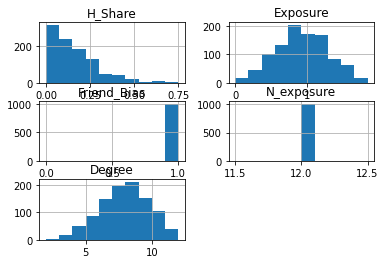

In [27]:

# parameter selection

# initial nodes and time
initial_n = 0
T = 250

p = 1

# parent nodes and prob
m = 8
pm_o = p

# parent neighbours and prob
n = 4
pn_o = p

rho = 5

# p high SES
p_SES_high = 0.5

new_sim = JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, rho=rho)


#plotly_sim_drawing.plotly_draw(plotly_sim_drawing(), new_sim, layout='spring', draw_largest_CC=True, title=f'Network after {T} iterations, rho={rho}')


sim_stats = new_sim.MTO_sim_many(new_sim.graph_history[-1], n_sims=1000)
sim_stats.head(5)
sim_stats.hist()


In [29]:



sp.stats.skew(sim_stats['H_Share'])



0.9689349955800841

## Testing

In [54]:

test_sim = JacksonSimulationV2(0, 250, 5, 0.25, 10, 0.25, 0.5, biased=True, rho=1.5)

plotly_sim_drawing.plotly_draw(plotly_sim_drawing(), test_sim, layout='spring', draw_largest_CC=True, title=f'Network after {250} iterations, rho={3}, w_H={0.5}')
